In [1]:
import pandas as pd
import numpy as np
import requests
import time
import datetime
import re
import string
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

In [19]:
def drop_duplicate_news(dataset):
    dataset= dataset.groupby('Texto', as_index=False).first()
    dataset = dataset.sort_values(by=['Data'])
    dataset = dataset[['Data', 'endereco', 'Texto', 'Num_Palavras-Chave', 'Traducao']]
    #dataset = dataset[['Data', 'Texto', 'Num_Palavras-Chave']]

    return dataset

def remove_useless(dataset, min_crit=1):

    palavras_chave = [
        'Agronegócio',
        'Agricultura',
        'Pecuária',
        'Agroindústria',
        'Produção Agrícola',
        'Cultivo',
        'Plantio',
        'Colheita',
        'Agropecuária',
        'Gestão Rural',
        'Tecnologia no Campo',
        'Irrigação',
        'Fertilizantes',
        'Defensivos Agrícolas',
        'Mercado Agrícola',
        'Exportação Agrícola',
        'Logística Agrícola',
        'Sustentabilidade no Agronegócio',
        'Agrobusiness',
        'Cadeia Produtiva'
    ]
    
    dataset['Texto'] = dataset['Texto'].astype(str)
    
    # Função para contar o número de palavras-chave encontradas em cada texto
    def count_keywords(text):
        return sum(keyword.lower() in text.lower() for keyword in palavras_chave)
    
    # Criar uma nova coluna com o número de palavras-chave encontradas para cada texto
    dataset['Num_Palavras-Chave'] = dataset['Texto'].apply(count_keywords)
    
    # Aplicar a máscara para manter apenas os textos relevantes
    mask = dataset['Num_Palavras-Chave'] >= min_crit
    dataset = dataset[mask]
    
    dataset.reset_index(drop=True, inplace=True)
    
    return dataset

def remove_stopwords_br(text):
    stop_words_pt = set(stopwords.words('portuguese'))    
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words_pt]
    return ' '.join(filtered_tokens)

def remove_stopwords_en(text):
    stop_words_pt = set(stopwords.words('english'))    
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words_pt]
    return ' '.join(filtered_tokens)

def remove_pontuaiton(text):
    punctuation = set(string.punctuation)
    for i in text:
        if i in punctuation:
            text = text.replace(i, "")
            
    return text

def remove_numbers(text):
    string = text
    return ''.join(filter(lambda z: not z.isdigit(), string))

def remove_expressoes(text):
    text = re.sub(r"\n", " ", text)
    text = re.sub(r'\r', " ", text)
    text = re.sub(r'-', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text

def translate(textos):

    lista_textos = list(textos['Texto'])
    list_tradução = []

    for texto in lista_textos:

        try:
            print(f'Caracteres Texto: {len(texto)}')
            texto_traduzido = TextBlob(texto).translate(from_lang="pt", to='en')
            list_tradução.append(texto_traduzido)
            print('Sucesso na primeira tentativa')
        
        except:

            try:
                print(f'Caracteres Texto: {len(texto)}')
                print("A primeira tentativa não foi. Segunda tentativa em 1 minuto")
                time.sleep(60)
                texto_traduzido = TextBlob(texto).translate(from_lang="pt", to='en')
                list_tradução.append(texto_traduzido)
                print("Sucesso na segunda tentativa")

            except:
                print("Erro na tradução, pulando para o proximo")
                texto_traduzido = "ERRO"
                list_tradução.append(texto_traduzido)
                
                
    textos['Traducao'] = list_tradução
    textos['Traducao'] = textos['Traducao'].map(lambda x:str(x))

    return textos



def tratar_dados(dataset):
    dataset = remove_useless(dataset)
    dataset = drop_duplicate_news(dataset)
    dataset.loc[:, 'Texto'] = dataset['Texto'].map(remove_expressoes)
    
    print("Iniciando Traduções")
    dataset = translate(dataset)
    
    dataset['Texto'] = dataset['Texto'].map(lambda x:str(x).lower())
    dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_stopwords_br)
    dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_stopwords_en)
    dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_pontuaiton)
    dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_numbers)

    dataset.to_excel('noticicas_tratadas_industria.xlsx', index = False)

    return dataset

In [3]:
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return []

def token_br(dataset_noticias):
    # Aplicar a tokenização à coluna 'texto'
    dataset_noticias['token'] = dataset_noticias['Texto'].apply(tokenize_text)

    # Replicar as linhas para cada palavra
    dataset_token = dataset_noticias.explode('token')
    dataset_token.drop(['Texto'], axis=1)
    dataset_token.reset_index(drop=True, inplace=True)

    return dataset_token

def token_en(dataset_noticias):
    # Aplicar a tokenização à coluna 'texto'
    dataset_noticias['token'] = dataset_noticias['Traducao'].apply(tokenize_text)

    # Replicar as linhas para cada palavra
    dataset_token = dataset_noticias.explode('token')
    dataset_token.drop(['Texto'], axis=1)
    dataset_token.reset_index(drop=True, inplace=True)

    return dataset_token


def sentiment_analysis_br(dataset_token):
    Loughan_Mc = pd.read_excel(r"C:\Users\eusou\OneDrive\Documentos\TCC\06. Dicionários\Loughran_McDonald_pt.xlsx")

    Loughan_Mc = Loughan_Mc.loc[(Loughan_Mc['sentimento'] == 'positivo') | (Loughan_Mc['sentimento'] == 'negativo')]
    
    sentiment_analysis = None
    sentiment_analysis = pd.merge(dataset_token, Loughan_Mc, on='token')
    sentiment_analysis['Data'] = pd.to_datetime(sentiment_analysis['Data'], format='%d/%m/%Y')
    sentiment_analysis = sentiment_analysis.groupby(['Data', 'sentimento']).size().unstack(fill_value=0)
    sentiment_analysis['Sentimento'] = ((sentiment_analysis['positivo'] - sentiment_analysis['negativo']) / (sentiment_analysis['positivo'] + sentiment_analysis['negativo']))

    sentiment_analysis.to_excel('Sentiment Analysis_industria_br.xlsx')

    return sentiment_analysis

def sentiment_analysis_en(dataset_token):
    Loughan_Mc = pd.read_excel(r"C:\Users\eusou\OneDrive\Documentos\TCC\06. Dicionários\Loughran_McDonald_en.xlsx")
    Loughan_Mc = Loughan_Mc.loc[(Loughan_Mc['sentiment'] == 'positive') | (Loughan_Mc['sentiment'] == 'negative')]
    
    sentiment_analysis = None
    sentiment_analysis = pd.merge(dataset_token, Loughan_Mc, on='token')
    sentiment_analysis['Data'] = pd.to_datetime(sentiment_analysis['Data'], format='%d/%m/%Y')
    sentiment_analysis = sentiment_analysis.groupby(['Data', 'sentiment']).size().unstack(fill_value=0)
    sentiment_analysis['sentiment'] = ((sentiment_analysis['positive'] - sentiment_analysis['negative']) / (sentiment_analysis['positive'] + sentiment_analysis['negative']))

    sentiment_analysis.to_excel('Sentiment Analysis_industria_en.xlsx')

    return sentiment_analysis


def normalize_sentiment(sentiment_analysis):
    mean = np.mean(sentiment_analysis['sentiment'])
    std = np.std(sentiment_analysis['sentiment'])
    sentiment_analysis['SS_NORMALIZE'] = ((sentiment_analysis['sentiment'] - mean)) / std

    sentiment_analysis.to_excel(f'Sentiment_Analysis_Indústria_en.xlsx')
    
    return sentiment_analysis

In [4]:
#dataset_text = pd.read_excel(r'C:\Users\eusou\OneDrive\Documentos\TCC\08. G1 Dataset\2.textos_completos_industria.xlsx')
#dataset_text = pd.read_excel(r'C:\Users\eusou\OneDrive\Documentos\TCC\08. G1 Dataset\2.textos_completos_mercado_trabalho.xlsx')
#dataset_text = pd.read_excel(r'C:\Users\eusou\OneDrive\Documentos\TCC\08. G1 Dataset\2.textos_completos_mercado_financeiro.xlsx')
#dataset_text = pd.read_excel(r'C:\Users\eusou\OneDrive\Documentos\TCC\08. G1 Dataset\2.textos_completos_serviços.xlsx')
dataset_text = pd.read_excel(r'C:\Users\eusou\OneDrive\Documentos\TCC\08. G1 Dataset\2.textos_completos_agro.xlsx')

In [5]:
dataset = remove_useless(dataset_text)
dataset = drop_duplicate_news(dataset)
dataset['Texto'] = dataset['Texto'].map(remove_expressoes)

In [ ]:
dataset = translate(dataset)
dataset.to_excel('df_temp.xlsx')

In [13]:
#CARREGA O DF TEMPORARIO COM AS TRADUÇÕES AUSENTES INPUTADAS MANUALMENTE
dataset = pd.read_excel(r'df_temp.xlsx')

In [14]:
dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(lambda x:str(x).lower())
dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_stopwords_br)
dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_stopwords_en)
dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_pontuaiton)
dataset[['Traducao', 'Texto']] = dataset[['Traducao', 'Texto']].applymap(remove_numbers)

In [2]:
dataset.to_excel('noticias_tratadas_agronegocio.xlsx')

NameError: name 'dataset' is not defined

In [29]:
noticias_tratadas = pd.read_excel(r'noticias_tratadas_agronegocio.xlsx')
tokens_en = token_en(noticias_tratadas)
sentiment_analysis_en = sentiment_analysis_en(tokens_en)
sentiment_analysis_en = normalize_sentiment(sentiment_analysis_en)

### TESTE

In [31]:
sentiment_analysis_br = pd.read_excel(r'C:\Users\eusou\OneDrive\Documentos\TCC\08. G1 Dataset\4.Sentiment_Analysis_Agronegocio_br.xlsx')

In [32]:
def plot_sentiment_analysis(sentiment_analysis_pt, sentiment_analysis_en, title:str):

    plt.figure(figsize=(12, 6))
    plt.plot(sentiment_analysis_pt.index, sentiment_analysis_pt['SS_NORMALIZE'], label='Sentimento', linestyle='-')
    plt.plot(sentiment_analysis_en.index, sentiment_analysis_en['SS_NORMALIZE'], label='sentiment', linestyle='-')

    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Contagem')
    plt.legend()
    plt.grid(True)
    return plt.show()

def semanalização1(sentiment_analysis):

    sentiment_analysis['Data'] = pd.to_datetime(sentiment_analysis['Data'])
    sentiment_analysis.set_index('Data', inplace=True)
    sentiment_analysis = sentiment_analysis.resample('M').mean()

    return sentiment_analysis

def semanalização2(sentiment_analysis):

    sentiment_analysis = sentiment_analysis.resample('M').mean()

    return sentiment_analysis

In [33]:
sentiment_analysis_br = semanalização1(sentiment_analysis_br)
sentiment_analysis_en = semanalização2(sentiment_analysis_en)

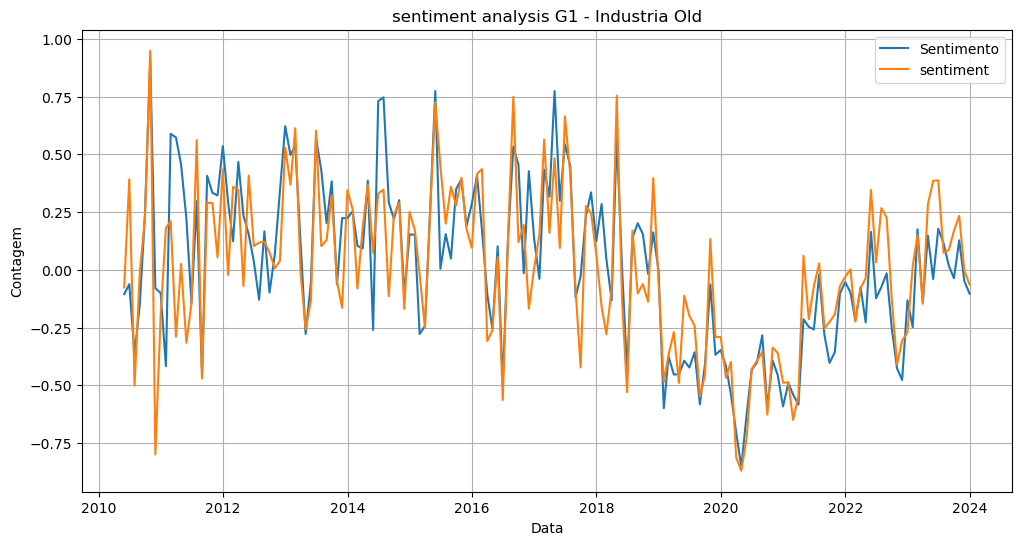

In [34]:
plot_sentiment_analysis(sentiment_analysis_br, sentiment_analysis_en, title= 'sentiment analysis G1 - Industria Old')